In [14]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from wordcloud import WordCloud
import re

import random

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from nltk.sentiment import SentimentIntensityAnalyzer
import joblib
from textblob import TextBlob

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


**Load data.**

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
path = '/content/drive/MyDrive/CS410 project/'

In [17]:
url = path+'/data/DisneylandReviews.csv'
df = pd.read_csv(url, encoding="cp1252")

In [18]:
print(df.shape)

(42656, 6)


# 1. Data Exploration

**1.1 Overview of the Dataset**

In [19]:
print(df.head())

   Review_ID  Rating Year_Month     Reviewer_Location  \
0  670772142       4     2019-4             Australia   
1  670682799       4     2019-5           Philippines   
2  670623270       4     2019-4  United Arab Emirates   
3  670607911       4     2019-4             Australia   
4  670607296       4     2019-4        United Kingdom   

                                         Review_Text               Branch  
0  If you've ever been to Disneyland anywhere you...  Disneyland_HongKong  
1  Its been a while since d last time we visit HK...  Disneyland_HongKong  
2  Thanks God it wasn   t too hot or too humid wh...  Disneyland_HongKong  
3  HK Disneyland is a great compact park. Unfortu...  Disneyland_HongKong  
4  the location is not in the city, took around 1...  Disneyland_HongKong  


In [20]:
# Check missing values
df.isna().sum()

,0
Review_ID,0
Rating,0
Year_Month,0
Reviewer_Location,0
Review_Text,0
Branch,0


Data Summary

In [21]:
print ("Rows     : " ,df.shape[0])
print ("Columns  : " ,df.shape[1])
print ("\nFeatures : \n" ,df.columns.tolist())
print ("\nMissing values :  ", df.isnull().sum().values.sum())
print ("\nUnique values :  \n",df.nunique())

Rows     :  42656
Columns  :  6

Features : 
 ['Review_ID', 'Rating', 'Year_Month', 'Reviewer_Location', 'Review_Text', 'Branch']

Missing values :   0

Unique values :  
 Review_ID            42636
Rating                   5
Year_Month             112
Reviewer_Location      162
Review_Text          42632
Branch                   3
dtype: int64


**1.2 Exploring the Target Variable**

In [22]:
df.Rating.value_counts()

,count
Rating,
5,23146
4,10775
3,5109
2,2127
1,1499


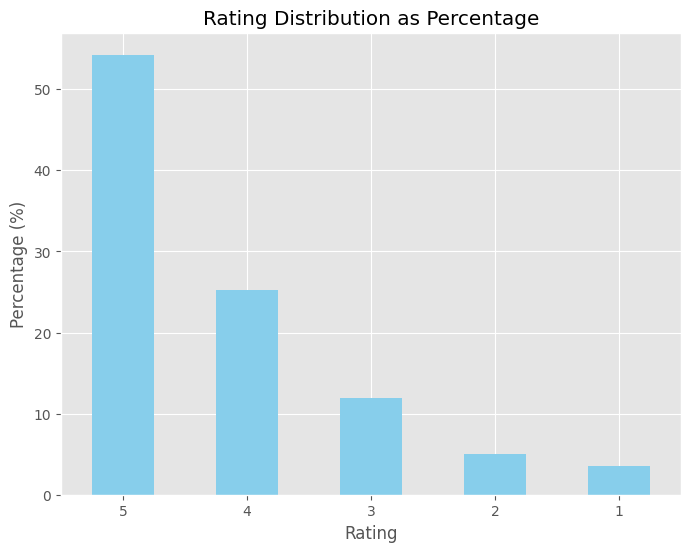

In [23]:
# Calculate the percentage of each rating
rating_counts = df['Rating'].value_counts(normalize=True) * 100  # Use normalize=True to convert counts to percentages

# Plot a bar chart
plt.figure(figsize=(8, 6))
rating_counts.plot(kind='bar', color='skyblue')
plt.title('Rating Distribution as Percentage')
plt.xlabel('Rating')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)  # Display x-axis labels horizontally
plt.show()

**1.3 Examining Raw Review Texts**

In [24]:
 #Group by rating and get a random Review_Text from each group
random_statements = df.groupby('Rating')['Review_Text'].apply(lambda x: x.sample(n=1).iloc[0])

# Print the results
for Rating, Review_Text in random_statements.items():
    print(f"Rating: {Rating}")
    print(f"Review: {Review_Text}\n")

Rating: 1
Review: I recently visited your Disneyland Theme Park and I had the absolutely worse and unpleasant experience as I was entering the shuttle area to go into the Disney theme park. Meek yelled at my family and embarrasses us in front of many guests and other staff. And on top of that, she refused to answer our questions about getting to the park! This was outrageous and very poor customer service.My family and I were dropped off in the  Woody  Shuttle area and we were yelled at by a staff member   MEEK (Chicago, IL). She was extremely rude and had poor customer service towards us. I understand that we were confused by which Shuttle area to wait at as there are many stops to choose from, Buzz Lightyear, Woody, ect., however as we were crossing the street to go to the Woody area   she immediately yelled  NO! GO BACK AROUND THE SIDEWALK! . We stopped on the sidewalk and asked  But we are looking for the shuttle to go to the park.  She continues to yell  NO! WALK AROUND THE SIDEWA

# 2. Text Preprocessing

**2.1. Lowercasing**

Convert all reviews to lowercase to ensure uniformity.

In [25]:
df.rename(columns={'processed_text': 'Review_Text'}, inplace=True)

# Convert all text in the 'Review_Text' column to lowercase for uniformity
df['processed_text']=df['Review_Text'].str.lower()
df.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch,processed_text
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,if you've ever been to disneyland anywhere you...
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,its been a while since d last time we visit hk...
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,thanks god it wasn t too hot or too humid wh...
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,hk disneyland is a great compact park. unfortu...
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,"the location is not in the city, took around 1..."


**2.2. Removing URLs, handles, punctuation and special characters**

To remove specific patterns such as URLs or other unwanted text from a column in a pandas DataFrame, we can use regular expressions with the re-module or pandas built-in string methods.

In [26]:
def remove_patterns(text):
    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)
    # Remove markdown-style links
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    # Remove handles (that start with '@')
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation and other special characters
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

# Apply the function to the 'processed_review' column
df['processed_text'] = df['processed_text'].apply(remove_patterns)
df.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch,processed_text
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,if youve ever been to disneyland anywhere youl...
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,its been a while since d last time we visit hk...
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,thanks god it wasn t too hot or too humid wh...
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,hk disneyland is a great compact park unfortun...
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,the location is not in the city took around 1 ...


**2.3. Stemming and Lemmatization**

Reduce words to their base or root form.

In [27]:
# Initialize the lemmatizer and stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Function to lemmatize and then stem each word in a sentence
def lemmatize_and_stem_text(text):
    words = word_tokenize(text)  # Tokenize the text
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]  # Lemmatize each word
    stemmed_words = [stemmer.stem(word) for word in lemmatized_words]  # Stem each lemmatized word
    return ' '.join(stemmed_words)

# Apply the function to the 'processed_review' column
df['stemmed_text'] = df['processed_text'].apply(lemmatize_and_stem_text)
df.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch,processed_text,stemmed_text
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,if youve ever been to disneyland anywhere youl...,if youv ever been to disneyland anywher youll ...
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,its been a while since d last time we visit hk...,it been a while sinc d last time we visit hk d...
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,thanks god it wasn t too hot or too humid wh...,thank god it wasn t too hot or too humid when ...
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,hk disneyland is a great compact park unfortun...,hk disneyland is a great compact park unfortun...
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,the location is not in the city took around 1 ...,the locat is not in the citi took around 1 hou...


**2.4. Stop Words**

Remove common words that add little meaning to the analysis (e.g., “the,” “and”), allowing focus on more relevant terms. Additionally, remove frequent but meaningless words like ‘thi’ and ‘wa’ to improve the clarity of the processed text.

In [28]:
# Define stopwords
stop_words = set(stopwords.words('english'))
stop_words.update(['thi', 'wa', 'ride', 'park', 'one', 'time', 'day', 'go',
                   'disney', 'disneyland', 'even', 'onli', 'u', 'kid'])  # Add custom stopwords

# Function to remove stopwords
def remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Apply the function to the DataFrame
df['cleaned_text'] = df['stemmed_text'].apply(remove_stopwords)

df.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch,processed_text,stemmed_text,cleaned_text
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,if youve ever been to disneyland anywhere youl...,if youv ever been to disneyland anywher youll ...,youv ever anywher youll find hong kong veri si...
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,its been a while since d last time we visit hk...,it been a while sinc d last time we visit hk d...,sinc last visit hk yet stay tomorrowland aka m...
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,thanks god it wasn t too hot or too humid wh...,thank god it wasn t too hot or too humid when ...,thank god hot humid visit otherwis would big i...
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,hk disneyland is a great compact park unfortun...,hk disneyland is a great compact park unfortun...,hk great compact unfortun quit bit mainten wor...
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,the location is not in the city took around 1 ...,the locat is not in the citi took around 1 hou...,locat citi took around 1 hour kowlon like much...


In [29]:
# re-labeling Review Text based on customers' ratings
def categorize_rating(rating):
  if rating in [1, 2]:
    return 'unsatisfied'
  elif rating == 3:
    return 'neutral'
  else:
    return 'satisfied'

In [30]:
df['num_of_characters'] = df['Review_Text'].str.len()
df['num_of_sentences'] = df['Review_Text'].apply(lambda x: len(nltk.sent_tokenize(x)))
df['rating_category'] = df['Rating'].apply(categorize_rating)

df.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch,processed_text,stemmed_text,cleaned_text,num_of_characters,num_of_sentences,rating_category
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,if youve ever been to disneyland anywhere youl...,if youv ever been to disneyland anywher youll ...,youv ever anywher youll find hong kong veri si...,329,4,satisfied
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,its been a while since d last time we visit hk...,it been a while sinc d last time we visit hk d...,sinc last visit hk yet stay tomorrowland aka m...,970,19,satisfied
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,thanks god it wasn t too hot or too humid wh...,thank god it wasn t too hot or too humid when ...,thank god hot humid visit otherwis would big i...,938,4,satisfied
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,hk disneyland is a great compact park unfortun...,hk disneyland is a great compact park unfortun...,hk great compact unfortun quit bit mainten wor...,485,3,satisfied
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,the location is not in the city took around 1 ...,the locat is not in the citi took around 1 hou...,locat citi took around 1 hour kowlon like much...,163,2,satisfied


**2.5. Word Clouds**

Generate and visualize word clouds to highlight the most frequent words for each rating category.

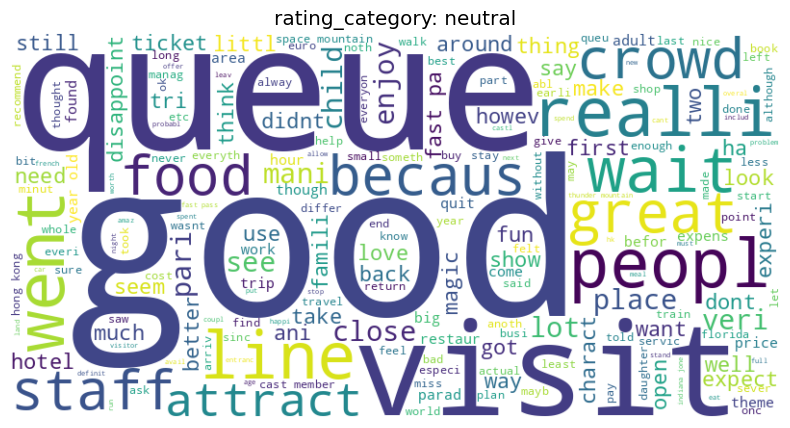

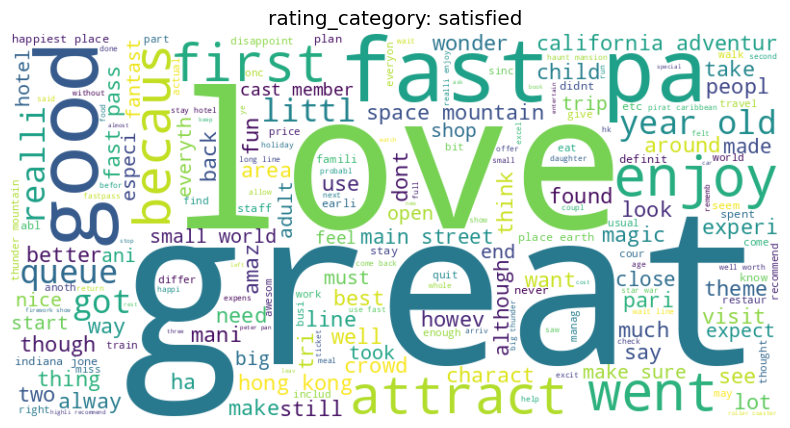

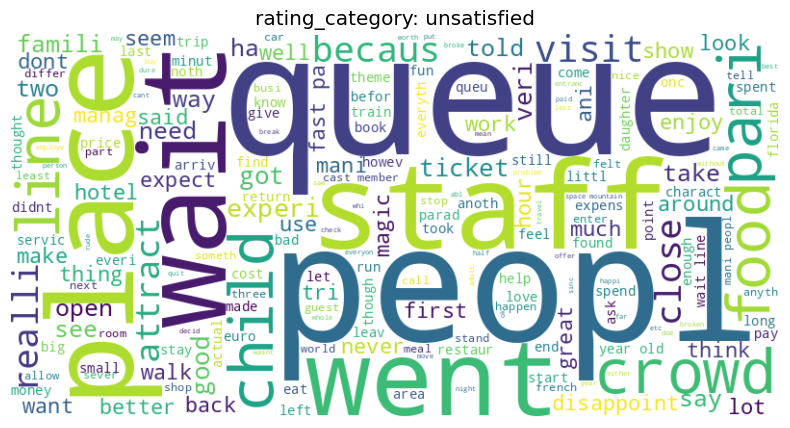

In [31]:
# Get unique ratings
ratings = df['rating_category'].unique()

# Filter reviews for the current rating
for i, rating in enumerate(sorted(ratings), 1):  # Sort ratings for consistency
    text = " ".join(review for review in df[df['rating_category'] == rating]['cleaned_text'])

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)

    # Plot the WordCloud
    plt.figure(figsize=(10, 5))   # Set up a figure for subplots
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'rating_category: {rating}')
    plt.show()

# 3. Data Preprocessing

**3.1. Separate features and labels**

In [125]:
# apply Sentiment features to data

analyzer = SentimentIntensityAnalyzer()

def get_sentiment_scores(text):
    sentiment = analyzer.polarity_scores(text)
    return pd.Series([sentiment['neg'], sentiment['neu'], sentiment['pos'], sentiment['compound']])

df[['Negative', 'Neutral', 'Positive', 'Compound']] = df['Review_Text'].apply(get_sentiment_scores)
df['Positive'] = df.apply(
    lambda row: row['Positive'] * 0.75 if row['Rating'] == 1 or row['Rating'] == 2 else row['Positive'], axis=1
)
df['Neutral'] = df.apply(
    lambda row: row['Neutral'] * 0.75 if row['Rating'] == 1 or row['Rating'] == 2 else row['Positive'], axis=1
)

In [126]:
from textblob import TextBlob

def get_textblob_sentiment(text):
    blob = TextBlob(text)
    return pd.Series([blob.sentiment.polarity, blob.sentiment.subjectivity])

df[['Polarity', 'Subjectivity']] = df['Review_Text'].apply(get_textblob_sentiment)



In [127]:
df.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch,processed_text,stemmed_text,cleaned_text,num_of_characters,num_of_sentences,rating_category,Negative,Neutral,Positive,Compound,Polarity,Subjectivity
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,if youve ever been to disneyland anywhere youl...,if youv ever been to disneyland anywher youll ...,youv ever anywher youll find hong kong veri si...,329,4,satisfied,0.000,0.113,0.113,0.7069,0.243981,0.561481
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,its been a while since d last time we visit hk...,it been a while sinc d last time we visit hk d...,sinc last visit hk yet stay tomorrowland aka m...,970,19,satisfied,0.040,0.231,0.231,0.9901,0.236131,0.434649
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,thanks god it wasn t too hot or too humid wh...,thank god it wasn t too hot or too humid when ...,thank god hot humid visit otherwis would big i...,938,4,satisfied,0.024,0.235,0.235,0.9920,0.160498,0.422944
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,hk disneyland is a great compact park unfortun...,hk disneyland is a great compact park unfortun...,hk great compact unfortun quit bit mainten wor...,485,3,satisfied,0.080,0.160,0.160,0.8489,0.189286,0.512143
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,the location is not in the city took around 1 ...,the locat is not in the citi took around 1 hou...,locat citi took around 1 hour kowlon like much...,163,2,satisfied,0.000,0.101,0.101,0.2846,0.266667,0.437500


In [128]:
df[df['Rating'] == 3].head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch,processed_text,stemmed_text,cleaned_text,num_of_characters,num_of_sentences,rating_category,Negative,Neutral,Positive,Compound,Polarity,Subjectivity
5,670591897,3,2019-4,Singapore,"Have been to Disney World, Disneyland Anaheim ...",Disneyland_HongKong,have been to disney world disneyland anaheim a...,have been to disney world disneyland anaheim a...,world anaheim tokyo feel hong kong realli smal...,966,9,neutral,0.073,0.172,0.172,0.9653,-0.065476,0.610397
7,670574142,3,2019-3,Malaysia,Think of it as an intro to Disney magic for th...,Disneyland_HongKong,think of it as an intro to disney magic for th...,think of it a an intro to disney magic for the...,think intro magic littl almost attract complet...,573,8,neutral,0.030,0.102,0.102,0.7902,0.054722,0.500556
15,670205135,3,2019-1,United Kingdom,We brought tickets before we left and got 2 da...,Disneyland_HongKong,we brought tickets before we left and got 2 da...,we brought ticket befor we left and got 2 day ...,brought ticket befor left got 2 less price 1 v...,509,4,neutral,0.058,0.073,0.073,0.3662,-0.060417,0.345139
17,670129921,3,2019-4,United Kingdom,Around 60 per person and if you want to eat ...,Disneyland_HongKong,around 60 per person and if you want to eat ...,around 60 per person and if you want to eat or...,around 60 per person want eat drink ani point ...,413,5,neutral,0.000,0.101,0.101,0.6757,-0.076871,0.468707
21,670022335,3,2019-4,United States,First off I'm not a really big Disneyland fan....,Disneyland_HongKong,first off im not a really big disneyland fan i...,first off im not a realli big disneyland fan i...,first im realli big fan live 20 minut californ...,896,11,neutral,0.009,0.134,0.134,0.9543,0.201256,0.518275


In [129]:
X = df[['cleaned_text', 'Negative', 'Neutral', 'Positive', 'Compound', 'num_of_characters', 'num_of_sentences']]
y = df['rating_category']

print("Features shape:", X.shape)
print("Labels shape:", y.shape)

Features shape: (42656, 7)
Labels shape: (42656,)


In [130]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

**3.2. One-Hot Encoding for Branch and Feature Combination**

Convert the 'Branch' column into dummy variables (one-hot encoding) for each Disneyland location，then combine the dummy variables with the 'cleaned_text' column to create the final feature set.

In [131]:
# branch_dummies = pd.get_dummies(X['Branch'], prefix='Branch')
# X = pd.concat([X['cleaned_text'], branch_dummies], axis=1)

print(X.head())

                                        cleaned_text  Negative  Neutral  \
0  youv ever anywher youll find hong kong veri si...     0.000    0.113   
1  sinc last visit hk yet stay tomorrowland aka m...     0.040    0.231   
2  thank god hot humid visit otherwis would big i...     0.024    0.235   
3  hk great compact unfortun quit bit mainten wor...     0.080    0.160   
4  locat citi took around 1 hour kowlon like much...     0.000    0.101   

   Positive  Compound  num_of_characters  num_of_sentences  
0     0.113    0.7069                329                 4  
1     0.231    0.9901                970                19  
2     0.235    0.9920                938                 4  
3     0.160    0.8489                485                 3  
4     0.101    0.2846                163                 2  


**3.3. Split the data into training and testing sets**

Convert the 'Branch' column into dummy variables (one-hot encoding) for each Disneyland location，then combine the dummy variables with the 'cleaned_text' column to create the final feature set.

In [132]:
# Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101, stratify=y)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (34124, 7)
Testing set size: (8532, 7)


**3.4. Convert text to features using TF-IDF**

Transform the 'cleaned_text' column into numerical features using TF-IDF. We use TF-IDF vectorization to capture the importance of words and phrases within each review.

In [133]:
# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(ngram_range=(2, 3), max_features=5000)

# Fit the vectorizer on the training data and transform both training and testing sets

X_train_tfidf = vectorizer.fit_transform(X_train['cleaned_text'])
X_test_tfidf = vectorizer.transform(X_test['cleaned_text'])

# Check the shape to ensure the transformation is successful
print("TF-IDF training set shape:", X_train_tfidf.shape)
print("TF-IDF testing set shape:", X_test_tfidf.shape)

joblib.dump(vectorizer, path+'tfidf_vectorizer.pkl')

TF-IDF training set shape: (34124, 5000)
TF-IDF testing set shape: (8532, 5000)


['/content/drive/MyDrive/CS410 project/tfidf_vectorizer.pkl']

Extract and split the branch dummy variables for train and test sets, and then combine TF-IDF features with branch dummy variables

In [134]:
# Extract and split the variables besides text context for train and test sets
X_train_sentiments = X_train[['Negative', 'Neutral', 'Positive', 'Compound','num_of_characters', 'num_of_sentences']]
X_test_sentiments = X_test[['Negative', 'Neutral', 'Positive', 'Compound','num_of_characters', 'num_of_sentences']]

# Convert the sentiment score features to sparse matrices
X_train_sentiments_sparse = X_train_sentiments.values
X_test_sentiments_sparse = X_test_sentiments.values

# # Combine TF-IDF features with branch dummy variables
X_train_combined = hstack([X_train_tfidf, X_train_sentiments_sparse])
X_test_combined = hstack([X_test_tfidf, X_test_sentiments_sparse])
# Display the shapes of the combined features
print("X_train_tfidf shape:", X_train_tfidf.shape)
print("X_train_branch shape:", X_train_sentiments_sparse.shape)
print("X_train_combined shape:", X_train_combined.shape)

print("X_test_tfidf shape:", X_test_tfidf.shape)
print("X_test_branch shape:", X_train_sentiments_sparse.shape)
print("X_test_combined shape:", X_test_combined.shape)

X_train_tfidf shape: (34124, 5000)
X_train_branch shape: (34124, 6)
X_train_combined shape: (34124, 5006)
X_test_tfidf shape: (8532, 5000)
X_test_branch shape: (34124, 6)
X_test_combined shape: (8532, 5006)


In [135]:
print('Number of feature words: ', len(vectorizer.get_feature_names_out()))

Number of feature words:  5000


In [136]:
# X_train_combined.shape

In [137]:
print(X_train_combined)

  (0, 475)	0.7090353214256403
  (0, 3375)	0.7051729667045092
  (1, 1406)	0.16480220621682246
  (1, 3954)	0.15838447560392993
  (1, 309)	0.1840887769273591
  (1, 1802)	0.1808836754532447
  (1, 1425)	0.3790942478888343
  (1, 1716)	0.16308492958634385
  (1, 1732)	0.1840887769273591
  (1, 1765)	0.38290830520593094
  (1, 4572)	0.108367400683039
  (1, 1368)	0.1738466422395125
  (1, 4600)	0.17139848613437764
  (1, 4543)	0.1711090017364841
  (1, 73)	0.13719865278748772
  (1, 2726)	0.3068895177730587
  (1, 1669)	0.18612838664831896
  (1, 147)	0.1628785051872106
  (1, 32)	0.12922646007594976
  (1, 2390)	0.10762609710045952
  (1, 2012)	0.15737908150872523
  (1, 4337)	0.14050612945158258
  (1, 2554)	0.19352252322804034
  (1, 2006)	0.17922465701316653
  (1, 2615)	0.17483178797162163
  :	:
  (34119, 5004)	608.0
  (34119, 5005)	7.0
  (34120, 5000)	0.099
  (34120, 5001)	0.223
  (34120, 5002)	0.223
  (34120, 5003)	0.971
  (34120, 5004)	646.0
  (34120, 5005)	6.0
  (34121, 5001)	0.247
  (34121, 5002)	0.2

# Model Training and Evaluating

In [138]:
# ros = RandomOverSampler(random_state=42)
# X_train_resampled, y_train_resampled = ros.fit_resample(X_train_combined, y_train)

# handle imbalanced dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_combined, y_train)

In [139]:
labels = label_encoder.classes_
labels

array(['neutral', 'satisfied', 'unsatisfied'], dtype=object)

In [140]:
# RandomForest Classifier
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42
)
rf.fit(X_train_resampled, y_train_resampled)
joblib.dump(rf, path+'random_forest_model.pkl')

# LightGBM Classifier
lgbm = LGBMClassifier(
    n_estimators=200,
    min_child_samples=20,
    class_weight='balanced',
    max_depth=10,
    learning_rate=0.3,
    random_state=42
)
lgbm.fit(X_train_resampled, y_train_resampled)
joblib.dump(lgbm, path+'lightgbm_model.pkl')

# SVC
svc = LinearSVC(
    C=10,
    max_iter=200,
    loss='hinge',
    random_state=42
)
svc.fit(X_train_resampled, y_train_resampled)
joblib.dump(svc, path+'svc_model.pkl')


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 5.270689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 511742
[LightGBM] [Info] Number of data points in the train set: 81408, number of used features: 5006
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

['/content/drive/MyDrive/CS410 project/svc_model.pkl']

In [141]:
# Load the saved models
rf_loaded = joblib.load(path+'random_forest_model.pkl')
lgbm_loaded = joblib.load(path+'lightgbm_model.pkl')
svc_loaded = joblib.load(path+'svc_model.pkl')
vectorizer = joblib.load(path+'tfidf_vectorizer.pkl')

In [142]:

models = {
    'RandomForest Classifier': rf_loaded,
    'LightGBM Classifier': lgbm_loaded,
    'SVC': svc_loaded
}

accuracy_scores = []

for name, model in models.items():
    y_pred = model.predict(X_test_combined)
    accuracy = accuracy_score(y_test, y_pred)
    print("\n")
    print(f"For {name}:")
    print(f"Accuracy: {accuracy:.4f}")

    labels = [str(label) for label in label_encoder.classes_]
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=labels))

    accuracy_scores.append(accuracy)




For RandomForest Classifier:
Accuracy: 0.8259
Confusion Matrix:
[[ 467  514   41]
 [ 867 5891   27]
 [   1   35  689]]
Classification Report:
              precision    recall  f1-score   support

     neutral       0.35      0.46      0.40      1022
   satisfied       0.91      0.87      0.89      6785
 unsatisfied       0.91      0.95      0.93       725

    accuracy                           0.83      8532
   macro avg       0.72      0.76      0.74      8532
weighted avg       0.85      0.83      0.83      8532



For LightGBM Classifier:
Accuracy: 0.8801
Confusion Matrix:
[[ 413  609    0]
 [ 414 6371    0]
 [   0    0  725]]
Classification Report:
              precision    recall  f1-score   support

     neutral       0.50      0.40      0.45      1022
   satisfied       0.91      0.94      0.93      6785
 unsatisfied       1.00      1.00      1.00       725

    accuracy                           0.88      8532
   macro avg       0.80      0.78      0.79      8532
weighted 



# Predict Review Rating Usage

In [143]:
analyzer = SentimentIntensityAnalyzer()

def get_sentiment_scores(text):
    sentiment = analyzer.polarity_scores(text)
    return pd.Series([sentiment['neg'], sentiment['neu'], sentiment['pos'], sentiment['compound']])

In [144]:
def preprocess_review(review_text):
    # Calculate the number of characters and sentences
    num_of_characters = len(review_text)
    num_of_sentences = len(nltk.sent_tokenize(review_text))

    # Get sentiment scores
    neg, neu, pos, compound = get_sentiment_scores(review_text)
    vectorizer = joblib.load(path+'tfidf_vectorizer.pkl')
    tfidf_vector = vectorizer.transform([review_text])

    additional_features = pd.DataFrame({
        'Negative': [neg],
        'Neutral': [neu],
        'Positive': [pos],
        'Compound': [compound],
        'num_of_characters': [num_of_characters],
        'num_of_sentences': [num_of_sentences]
    })

    print(additional_features)

      # Concatenate TF-IDF features and additional features
    combined_features = pd.concat(
        [pd.DataFrame(tfidf_vector.toarray()), additional_features.reset_index(drop=True)],
        axis=1
    )
    return combined_features

In [156]:
def predict_review_rating(review_text):
  model = joblib.load(path+'random_forest_model.pkl')

  processed_review = preprocess_review(review_text)
  processed_review.columns = processed_review.columns.astype(str)


  labels = ['neutral', 'satisfied', 'unsatisfied']
  label_encoder = LabelEncoder()
  label_encoder.fit(labels)

  predicted_encoded_label = model.predict(processed_review)[0]
  print(predicted_encoded_label)

  predicted_category = label_encoder.inverse_transform([predicted_encoded_label])[0]
  print(f"Predicted Category: {predicted_category}")



# Example review text
review_text = "omg it's tired"
predict_review_rating(review_text)

   Negative  Neutral  Positive  Compound  num_of_characters  num_of_sentences
0     0.592    0.408       0.0   -0.4404                 14                 1
2
Predicted Category: unsatisfied
